In [68]:
import time
from pylab import *
from ipywidgets import interact
%matplotlib inline
%config InlineBackend.figure_formats = ['svg']
import numpy as np
import scipy as sp
import warnings
warnings.filterwarnings('ignore')
from IPython.display import clear_output, HTML, display, Image

In [92]:
class HeatEquationSolver_2():
    '''
    Класс для численного решения двумерного уравнения теплопроводности.
    '''
    def __init__(self,
                 X_START=0, X_END=2,
                 Y_START=0, Y_END=1,
                 T_START=0, T_END=20,
                 N=5, M=5, J=5):
        
        self.X_START = X_START
        self.X_END = X_END
        self.Y_START = Y_START
        self.Y_END = Y_END
        self.T_START = T_START
        self.T_END = T_END
        self.N = N
        self.M = M
        self.J = J
        
        self.x = np.linspace(X_START, X_END, N)
        self.y = np.linspace(Y_START, Y_END, M)
        self.t = np.linspace(T_START, T_END, J)
        
        self.dx = self.x[1] - self.x[0]
        self.dy = self.y[1] - self.y[0]
        self.dt = self.t[1] - self.t[0]
    
    def initialize(self, a=1, f=lambda x, y, t:0, fi=lambda x, y:0,
                   alpha1x=0, alpha2x=0, beta2x=0, beta1x=0, mu1x=lambda y, t:0, mu2x=lambda y, t:0,
                   alpha1y=0, alpha2y=0, beta2y=0, beta1y=0, mu1y=lambda x, t:0, mu2y=lambda x, t:0):
        '''
        Задание коэффициентов и функций конкретной задачи.
        '''
        
        self.a = a  # Коэффициент при операторе Лапласа
        self.f = f  # Функция "источника тепла" - неоднородность
        self.fi = fi  # Начальное условие
        
        self.alpha1x = alpha1x  # Коэффициент при левом условии Неймана для x
        self.alpha2x = alpha2x  # Коэффициент при правом условии Неймана для x
        self.beta1x = beta1x  # Коэффициент при левом условии Дирихле для x
        self.beta2x = beta2x  # Коэффициент при правом условии Дирихле для x
        self.mu1x = mu1x # Правая часть левого граничного условия для x
        self.mu2x = mu2x # Правая часть правого граничного условия для x
        
        self.alpha1y = alpha1y  # Коэффициент при левом условии Неймана для y
        self.alpha2y = alpha2y  # Коэффициент при правом условии Неймана для y
        self.beta1y = beta1y  # Коэффициент при правом условии Дирихле для y
        self.beta2y = beta2y  # Коэффициент при левом условии Дирихле для y
        self.mu1y = mu1y # Правая часть левого граничного условия для y
        self.mu2y = mu2y # Правая часть правого граничного условия для y
        
        self.u = np.zeros((self.J, self.N, self.M))  # Создание трехмерного массива значений u(x, y, t)
        
        self.u[0] = [[self.fi(x, y) for y in self.y] for x in self.x]  # Применение начального условия
        
    def calculate_layer(self, j):
        '''
        Метод, который вычисляет значения функции u(x, y, t) на временном слое номер j,
        используя предыдущий слой номер j-1.
        '''
        
        step_x = self.dx
        step_y = self.dt
        step_t = self.dt/2  # Уменьшим шаг по времени в 2 раза, чтобы получить промежуточный слой

        Dx = 1/step_x; Dy = 1/step_y;
        Dxx = Dx**2; Dyy = Dy**2
        
        # Переход к промежуточному слою, задание коэффициентов для метода прогонки
        middle_layer = np.zeros(shape=(self.M, self.N))
        for m in range(self.M):
            data = np.zeros((self.N, self.N))
            #Учет граничных условий
            data[0][0] = self.beta1x - self.alpha1x*Dx
            data[0][1] = self.alpha1x*Dx
            data[-1][-2] = -self.alpha2x*Dx 
            data[-1][-1] = self.alpha2x*Dx + self.beta2x
                
            for i in range(1, self.N - 1):
                data[i][i-1] = -self.a**2*step_t*Dxx
                data[i][i] = (2*self.a**2*step_t*Dxx + 1)
                data[i][i+1] = -self.a**2*step_t*Dxx
        
            F = [0]*self.N
            F[0], F[-1] = self.mu1x(self.y[m], self.t[j]+step_t), self.mu2x(self.y[m], self.t[j]+step_t)
            for k in range(1, self.N-1):
                F[k] = (self.f(self.x[k], self.y[m], self.t[j]+step_t)*step_t + self.u[j-1][k][m] + 
                        self.a**2*step_t*Dyy * (self.u[j-1][k-1][m] - 2*self.u[j-1][k][m] + self.u[j-1][k+1][m]))
                
            middle_layer[m] = sp.linalg.solve(data, F)  # Применение метода прогонки
            
        middle_layer = middle_layer.T  # Транспонирование 

        # Переход к новому слою, задание коэффициентов для метода прогонки
        new_layer = np.zeros(shape=(self.M, self.N))
        
        for n in range(self.N):
            data = np.zeros((self.M, self.M))
            # Учет граничных условий
            data[0][0] = self.beta1y - self.alpha1y*Dy
            data[0][1] = self.alpha1y*Dy
            data[-1][-2] = self.alpha2y*Dy 
            data[-1][-1] = self.alpha2y*Dy + self.beta2y
        
        
            for i in range(1, self.M - 1):
                data[i][i-1] = -self.a**2*step_t*Dyy
                data[i][i] = (2*self.a**2*step_t*Dyy + 1)
                data[i][i+1] = -self.a**2*step_t*Dyy
        
            F = [0]*self.M
            F[0], F[-1] = self.mu1y(self.x[n], self.t[j]+2*step_t), self.mu2y(self.x[n], self.t[j]+2*step_t)
            for k in range(1, self.M-1):
                F[k] = (self.f(self.x[n], self.y[k], self.t[j]+2*step_t)*step_t + middle_layer[n][k] + 
                        self.a**2*step_t*Dxx * (middle_layer[n][k-1] - 2*middle_layer[n][k] + middle_layer[n][k+1]))
                
            new_layer[n] = sp.linalg.solve(data, F)  # Применение метода прогонки
        
        new_layer = np.array(new_layer)
        
        return new_layer
           
    def calculate_u(self):
        print('Calculating...')
        for j in range(1, self.J):
            clear_output(wait = True)
            print(f'Progress: {round(j/(self.J-1), 2)*100}%')
            new_layer = self.calculate_layer(j)
            self.u[j] = new_layer
        
    def plot_state(self, n = 0):
        '''
        Метод, который строит график u(x, y, t) в момент времени на n% от временного интервала.
        
         Параметры:
            n (double): Число от 0 до 100 (при n > 100 считается, что n = 100).
        '''
        
        num = int(round(n/100*self.J, 0))
        if num>self.J-1:
            num = self.J-1

        cp1=contourf(self.x,self.y,self.u[num],10,cmap='coolwarm')
        colorbar()
        cp1=contour(self.x,self.y,self.u[num],10,colors='k')
        clabel(cp1,inline=True, fontsize=10)
        show()
        
    def plot_initial_state(self):
        '''
        Метод, который строит график начального условия.
        '''
        
        self.plot_state(n = 0)
    
 

In [93]:
solver = HeatEquationSolver_2(N = 50, M = 50, J = 50, T_END = 2)
a = 1
def f(x, y, t):
    return np.sin(10*t)
def fi(x, y):
    return np.cos(np.pi*x/4)*y*(1-y)
alpha1x = 1
alpha2x = 0
alpha1y = 0
alpha2y = 0
beta1x = 0
beta2x = 1
beta1y = 1
beta2y = 1
solver.initialize(a = a, f = f, fi = fi,
                  alpha1x = alpha1x, alpha2x = alpha2x, alpha1y = alpha1y, alpha2y = alpha2y,
                  beta1x = beta1x, beta2x = beta2x, beta1y = beta1y, beta2y = beta2y)

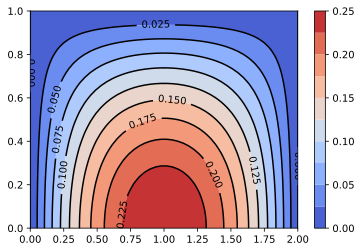

In [94]:
solver.plot_initial_state()

In [97]:
solver.calculate_u()

Progress: 100.0%


In [96]:
def var(n):
    solver.plot_state(n = n)

interact(var, n=(0, 100, 1))

interactive(children=(IntSlider(value=50, description='n'), Output()), _dom_classes=('widget-interact',))

<function __main__.var(n)>